In [3]:
import pandas as pd
import numpy as np
import os

# --- CONFIGURATION ---
RAW_DATA_PATH = "../data/raw/online_retail_II.xlsx"
PROCESSED_DATA_PATH = "../data/processed/online_retail_cleaned.csv"

# 1. LOAD DATA 
print("Loading raw data...")
df_2009 = pd.read_excel(RAW_DATA_PATH, sheet_name='Year 2009-2010')
df_2010 = pd.read_excel(RAW_DATA_PATH, sheet_name='Year 2010-2011')

# Combine both sheets
df = pd.concat([df_2009, df_2010], ignore_index=True)
print(f"Initial Row Count: {df.shape[0]:,}")

# 2. CLEANING: Remove Null CustomerIDs
# We cannot segment customers if we don't know who they are.
df = df.dropna(subset=['Customer ID'])
print(f"Rows after dropping null Customer ID: {df.shape[0]:,}")

# 3. CLEANING: Remove Cancellations & Bad Data
# Remove invoices starting with 'C' (Cancellations)
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Remove records with negative or zero Quantity/Price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# 4. CLEANING: Filter Operational 'Junk' Codes
junk_codes = ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'BANK CHARGES']
df = df[~df['StockCode'].isin(junk_codes)]

# 5. FEATURE ENGINEERING: Total Sales
df['TotalSales'] = df['Quantity'] * df['Price']

# 6. SAVE TO PROCESSED
#save as CSV to load faster next time.
print("Saving cleaned data...")
df.to_csv(PROCESSED_DATA_PATH, index=False)
print(f"SUCCESS! Final Cleaned Data Saved to: {PROCESSED_DATA_PATH}")
print(f"Final Row Count: {df.shape[0]:,}")

Loading raw data...
Initial Row Count: 1,067,371
Rows after dropping null Customer ID: 824,364
Saving cleaned data...
SUCCESS! Final Cleaned Data Saved to: ../data/processed/online_retail_cleaned.csv
Final Row Count: 802,932


In [4]:
#EXECUTING THE TRANSFORMATION


# CONFIGURATION 
# setting the 'Snapshot Date' to 1 day after the last transaction in the dataset
# This simulates doing the analysis on the day the data was pulled.
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

print(f"Snapshot Date: {snapshot_date}")

# AGGREGATION 
# Group by CustomerID and calculate RFM metrics
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalSales': 'sum'                                       # Monetary
})

# Rename columns for clarity
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSales': 'Monetary'
}, inplace=True)

# Sanity Check
print(f"Customer Count: {rfm.shape[0]}")
display(rfm.head())

Snapshot Date: 2011-12-10 12:50:00
Customer Count: 5862


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,1658.40
12349.0,19,3,3678.69
12350.0,310,1,294.40


Data Normalized! Mean should be ~0 and Std ~1.
       Recency  Frequency  Monetary
count  5862.00    5862.00   5862.00
mean      0.00       0.00     -0.00
std       1.00       1.00      1.00
min      -2.41      -1.06     -3.93
25%      -0.74      -1.06     -0.71
50%       0.08      -0.20     -0.03
75%       0.95       0.66      0.66
max       1.38       5.43      4.69

Running Elbow Method to find optimal K


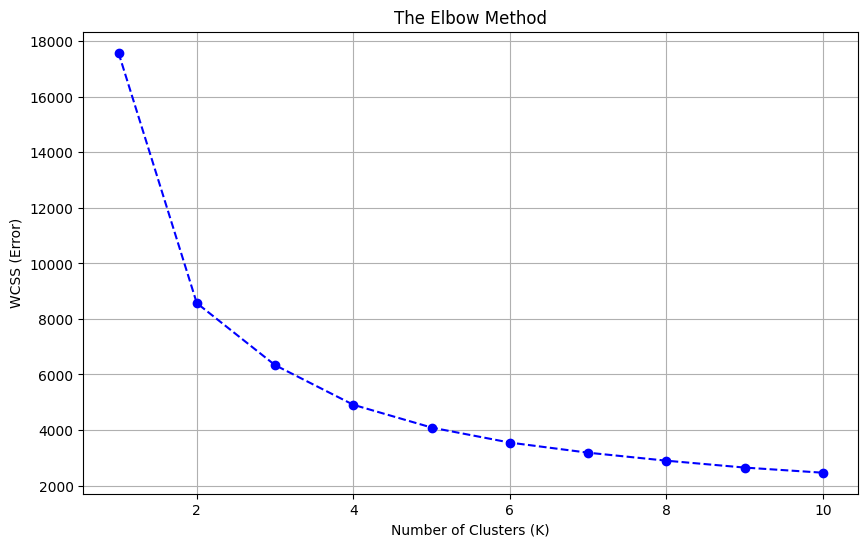

In [7]:
#PREPROCESSING AND ELBOW METHOD 
#this phase is used to determine the o of clusters can be formed and make a data more precised for the model generation 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. PREPROCESSING 
# Log transform to handle skewness (we add +1 to handle zeros)
rfm_log = np.log(rfm + 1)

# Initialize the Scaler
scaler = StandardScaler()

# Fit and Transform (Results in a numpy array)
rfm_normalized = scaler.fit_transform(rfm_log)

# Convert back to DataFrame for easier handling later
rfm_scaled = pd.DataFrame(rfm_normalized, index=rfm.index, columns=rfm.columns)

print("Data Normalized! Mean should be ~0 and Std ~1.")
print(rfm_scaled.describe().round(2))

# 2. THE ELBOW METHOD 
print("\nRunning Elbow Method to find optimal K")
wcss = [] # Within-Cluster Sum of Square

# Loop through 1 to 10 clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Error)')
plt.grid(True)
plt.show()

here the curve shows the diminishing returns(proportionally less profit gain as more money is invested). As a graph shows the straight dip at point 3 so here the K=3 but here we use the K=4 because the K=4 is far superior that the k-3. here the K=3 shows the data only in low, medium and high and K=4 gives the way to enter the new user in the data.

Customer Segments Profile:


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,394.72,1.42,346.51,2048
1,209.60,5.42,2122.42,1460
2,25.65,19.83,11295.45,1116
3,28.40,2.98,838.16,1238


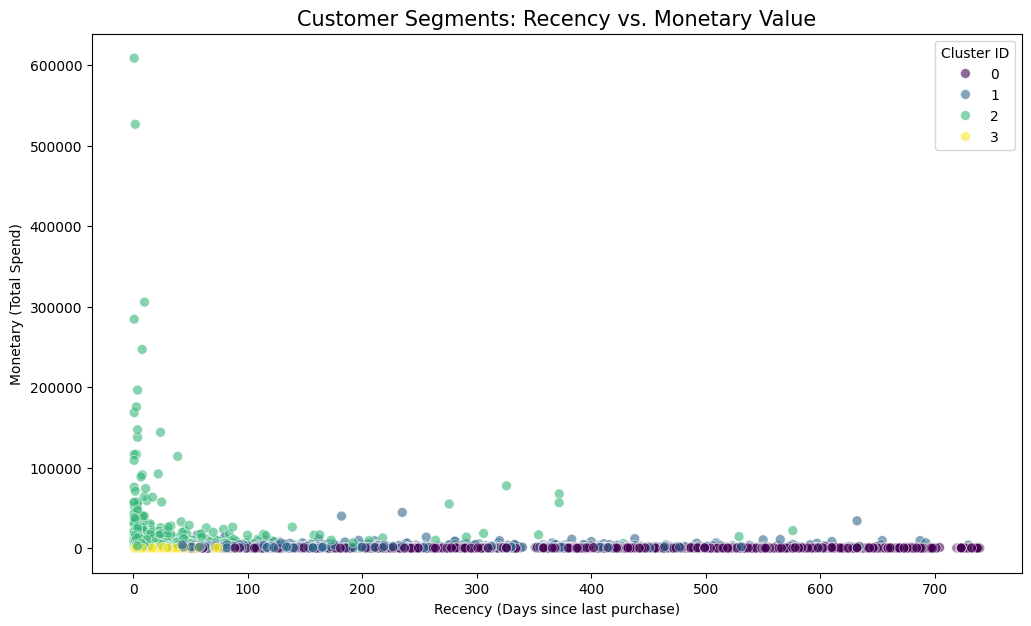

In [8]:
import seaborn as sns

# 1. Training the Model with K=4
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 2. The Interpretation Table 
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'})

print("Customer Segments Profile:")
display(cluster_summary.round(2))

# 3. VISUALIZATION: The Scatter Plot
# maping Recency vs. Monetary to see the separation
plt.figure(figsize=(12, 7))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=50, alpha=0.6)
plt.title('Customer Segments: Recency vs. Monetary Value', fontsize=15)
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster ID')
plt.show()

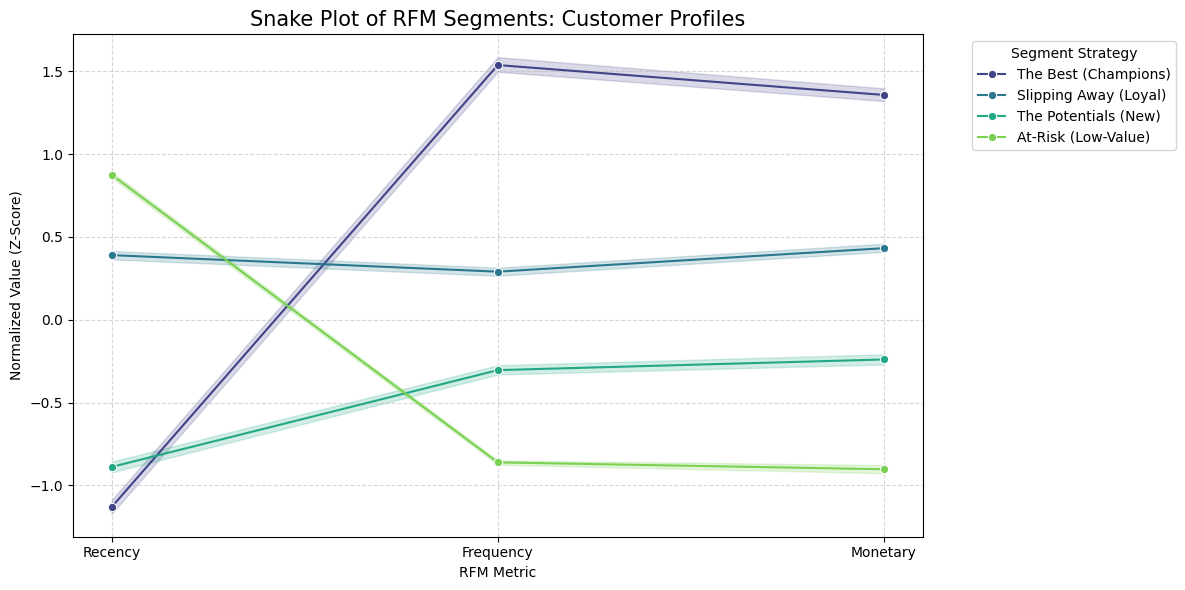

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare the scaled data
df_normalized = pd.DataFrame(rfm_scaled, index=rfm.index, columns=['Recency', 'Frequency', 'Monetary'])
df_normalized['Cluster'] = rfm['Cluster']

# 2. Define the Mapping Dictionary exactly as requested
cluster_map = {
    2: 'The Best (Champions)',
    3: 'The Potentials (New)',
    1: 'Slipping Away (Loyal)',
    0: 'At-Risk (Low-Value)'
}

# Apply the descriptive names to the Cluster column
df_normalized['Cluster'] = df_normalized['Cluster'].map(cluster_map)

# 3. "Melt" the data for plotting
df_melt = pd.melt(df_normalized.reset_index(), 
                  id_vars=['Cluster'], 
                  value_vars=['Recency', 'Frequency', 'Monetary'], 
                  var_name='Metric', 
                  value_name='Value')

# 4. Create the Named Snake Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Metric', y='Value', hue='Cluster', data=df_melt, palette='viridis', marker='o')

plt.title('Snake Plot of RFM Segments: Customer Profiles', fontsize=15)
plt.xlabel('RFM Metric')
plt.ylabel('Normalized Value (Z-Score)')
plt.legend(title='Segment Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [10]:
# --- 1. SET THE TIME MACHINE ---
# We select a cutoff date 90 days before the end of the dataset
cutoff_date = df['InvoiceDate'].max() - pd.DateOffset(days=90)
print(f"The 'Time Machine' Cutoff Date is: {cutoff_date}")

# --- 2. SPLIT THE DATA ---
# X (Features): Behavior BEFORE the cutoff
train_df = df[df['InvoiceDate'] < cutoff_date]

# y (Target): Behavior AFTER the cutoff
test_df = df[df['InvoiceDate'] >= cutoff_date]

# --- 3. GENERATE FEATURES (X) ---
# We calculate RFM again, but ONLY looking at the past
targets = train_df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (cutoff_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSales': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSales': 'Monetary'
})

# --- 4. GENERATE LABELS (y) ---
# Identify customers who bought something AFTER the cutoff
known_active_customers = test_df['Customer ID'].unique()

# If a customer exists in 'targets' but NOT in 'known_active_customers', they Churned.
targets['Churn'] = targets.index.isin(known_active_customers).astype(int)
# Invert logic: 1 = Churned (Did NOT buy), 0 = Retained (Did buy)
targets['Churn'] = 1 - targets['Churn'] 

print("Target Table Created!")
display(targets.head())

# Check the balance
print("\nChurn Distribution:")
print(targets['Churn'].value_counts(normalize=True))

The 'Time Machine' Cutoff Date is: 2011-09-10 12:50:00
Target Table Created!


,Recency,Frequency,Monetary,Churn
Customer ID,,,,
12346.0,235,12,77556.46,1
12347.0,39,6,4114.18,0
12348.0,158,4,1388.40,0
12349.0,317,2,2221.14,0
12350.0,219,1,294.40,1



Churn Distribution:
Churn
1    0.565325
0    0.434675
Name: proportion, dtype: float64


here the churn result is 56.5% it shows the dataset is completely balanced. Now next step is supervised learning in this step we are going to calculate the 1 and 0 using XGBoostClassifier.

In [ ]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Training XGBoost Model...

--- Model Performance Report ---
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       468
           1       0.74      0.82      0.78       586

    accuracy                           0.74      1054
   macro avg       0.74      0.73      0.74      1054
weighted avg       0.74      0.74      0.74      1054



<Figure size 1000x500 with 0 Axes>

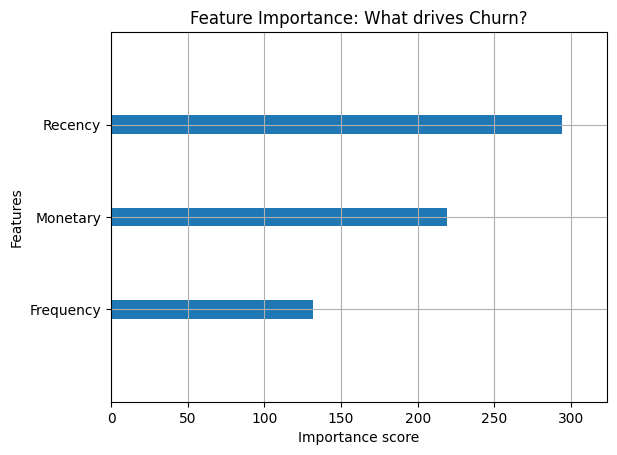

In [11]:
#Training The Prediction model 
#it consist three steps 
#1: split = spliting the data into train and test.
#2: Train = use Xgboost for standard tabular data.
#3: Evaluation = To check the no churners caught


from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. PREPARE DATA ---
# X = The features (RFM scores)
# y = The target (Churn 1/0)
X = targets[['Recency', 'Frequency', 'Monetary']]
y = targets['Churn']

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. TRAIN MODEL ---
# We use XGBoost because it handles non-linear relationships better than Logistic Regression
print("Training XGBoost Model...")
model = XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)

# --- 3. EVALUATE ---
# Make predictions on the test set
y_pred = model.predict(X_test)

print("\n--- Model Performance Report ---")
print(classification_report(y_test, y_pred))

# --- 4. VISUALIZE IMPORTANCE ---
# This tells us WHICH factor drives churn the most
plt.figure(figsize=(10, 5))
plot_importance(model, importance_type='weight', title='Feature Importance: What drives Churn?', show_values=False)
plt.show()

In the above Classification report we got recall = 0.82 it means we got a 82% churns and our accuracy is 74% 

In [12]:
#Now in this step we are going to save the model for future use and also save the important features that drive the churn so that we can use it in our marketing strategy.

import joblib

# Define the path (using the folder structure we created)
model_path = '../models/xgboost_churn.pkl'

# Save the trained model
joblib.dump(model, model_path)

print(f"Model saved to {model_path}")

Model saved to ../models/xgboost_churn.pkl
